In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [2]:
BATCHSIZE=64
data_dir = '../fish'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=BATCHSIZE)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=BATCHSIZE)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)


['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_06', 'fish_07', 'fish_08', 'fish_09', 'fish_10', 'fish_11', 'fish_12', 'fish_13', 'fish_14', 'fish_15', 'fish_16']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 16),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
epochs = 16
steps = 0
running_loss = 0
print_every = 16
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model.state_dict(),'model.pth')

Epoch 1/16.. Train loss: 2.614.. Test loss: 1.442.. Test accuracy: 0.548
Epoch 1/16.. Train loss: 1.067.. Test loss: 0.869.. Test accuracy: 0.733
Epoch 1/16.. Train loss: 0.767.. Test loss: 0.633.. Test accuracy: 0.819
Epoch 1/16.. Train loss: 0.587.. Test loss: 0.556.. Test accuracy: 0.835
Epoch 1/16.. Train loss: 0.560.. Test loss: 0.465.. Test accuracy: 0.861
Epoch 1/16.. Train loss: 0.520.. Test loss: 0.413.. Test accuracy: 0.881
Epoch 1/16.. Train loss: 0.420.. Test loss: 0.417.. Test accuracy: 0.867
Epoch 1/16.. Train loss: 0.459.. Test loss: 0.350.. Test accuracy: 0.901
Epoch 1/16.. Train loss: 0.440.. Test loss: 0.360.. Test accuracy: 0.888
Epoch 1/16.. Train loss: 0.479.. Test loss: 0.340.. Test accuracy: 0.893
Epoch 1/16.. Train loss: 0.350.. Test loss: 0.346.. Test accuracy: 0.893
Epoch 1/16.. Train loss: 0.334.. Test loss: 0.303.. Test accuracy: 0.903
Epoch 1/16.. Train loss: 0.326.. Test loss: 0.324.. Test accuracy: 0.903
Epoch 1/16.. Train loss: 0.335.. Test loss: 0.274..

Epoch 6/16.. Train loss: 0.194.. Test loss: 0.195.. Test accuracy: 0.935
Epoch 6/16.. Train loss: 0.180.. Test loss: 0.232.. Test accuracy: 0.924
Epoch 6/16.. Train loss: 0.232.. Test loss: 0.200.. Test accuracy: 0.937
Epoch 6/16.. Train loss: 0.195.. Test loss: 0.199.. Test accuracy: 0.936
Epoch 6/16.. Train loss: 0.153.. Test loss: 0.208.. Test accuracy: 0.938
Epoch 6/16.. Train loss: 0.189.. Test loss: 0.178.. Test accuracy: 0.944
Epoch 6/16.. Train loss: 0.219.. Test loss: 0.220.. Test accuracy: 0.930
Epoch 6/16.. Train loss: 0.255.. Test loss: 0.207.. Test accuracy: 0.938
Epoch 6/16.. Train loss: 0.189.. Test loss: 0.193.. Test accuracy: 0.938
Epoch 6/16.. Train loss: 0.186.. Test loss: 0.190.. Test accuracy: 0.941
Epoch 6/16.. Train loss: 0.252.. Test loss: 0.182.. Test accuracy: 0.945
Epoch 6/16.. Train loss: 0.204.. Test loss: 0.196.. Test accuracy: 0.941
Epoch 6/16.. Train loss: 0.230.. Test loss: 0.181.. Test accuracy: 0.941
Epoch 6/16.. Train loss: 0.161.. Test loss: 0.206..

Epoch 11/16.. Train loss: 0.151.. Test loss: 0.167.. Test accuracy: 0.947
Epoch 11/16.. Train loss: 0.183.. Test loss: 0.178.. Test accuracy: 0.946
Epoch 11/16.. Train loss: 0.162.. Test loss: 0.166.. Test accuracy: 0.951
Epoch 11/16.. Train loss: 0.149.. Test loss: 0.168.. Test accuracy: 0.952
Epoch 11/16.. Train loss: 0.170.. Test loss: 0.176.. Test accuracy: 0.947
Epoch 11/16.. Train loss: 0.195.. Test loss: 0.159.. Test accuracy: 0.952
Epoch 11/16.. Train loss: 0.190.. Test loss: 0.213.. Test accuracy: 0.930
Epoch 11/16.. Train loss: 0.218.. Test loss: 0.172.. Test accuracy: 0.947
Epoch 12/16.. Train loss: 0.221.. Test loss: 0.205.. Test accuracy: 0.934
Epoch 12/16.. Train loss: 0.220.. Test loss: 0.224.. Test accuracy: 0.937
Epoch 12/16.. Train loss: 0.236.. Test loss: 0.234.. Test accuracy: 0.929
Epoch 12/16.. Train loss: 0.238.. Test loss: 0.224.. Test accuracy: 0.932
Epoch 12/16.. Train loss: 0.198.. Test loss: 0.183.. Test accuracy: 0.944
Epoch 12/16.. Train loss: 0.194.. Test

Epoch 16/16.. Train loss: 0.162.. Test loss: 0.170.. Test accuracy: 0.948
Epoch 16/16.. Train loss: 0.173.. Test loss: 0.154.. Test accuracy: 0.954
Epoch 16/16.. Train loss: 0.132.. Test loss: 0.150.. Test accuracy: 0.954
Epoch 16/16.. Train loss: 0.165.. Test loss: 0.195.. Test accuracy: 0.942


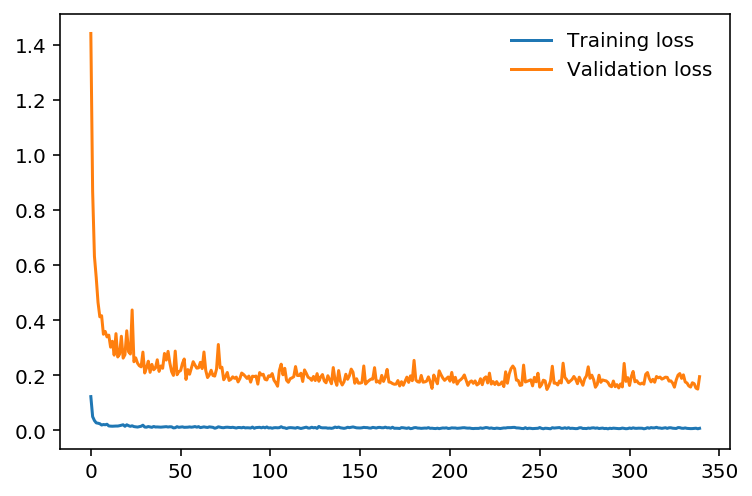

In [6]:

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()